# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

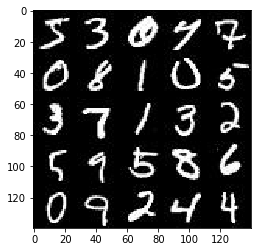

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

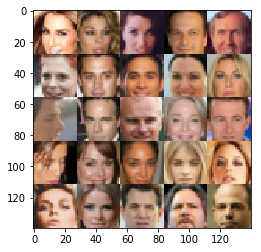

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_image")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="lr")
    return inputs_image, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
from functools import reduce

def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    
    alpha = 0.01
    training = True if reuse is False else False
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        # input images is of real image size
        h1 = tf.layers.conv2d(images, 64, (5, 5), strides=(2, 2), padding="same")
        # I am told not to use batch_normalization on the 1st layer bn1 = tf.layers.batch_normalization(h1, training=training)        
        relu1 = tf.maximum(alpha * h1, h1)
        
        # relu1 is of half_size * half_size * 64
        h2 = tf.layers.conv2d(relu1, 128, (5, 5), strides=(2, 2), padding="same")
        bn2 = tf.layers.batch_normalization(h2, training=training)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # relu1 is of quarter_size * quarter_size * 128
        h3 = tf.layers.conv2d(relu2, 256, (5, 5), strides=(2, 2), padding="same")
        bn3 = tf.layers.batch_normalization(h3, training=training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        relu3 = tf.reshape(relu3, (-1, int(reduce((lambda x, y: x * y), relu3.shape[1:]))))
        logits = tf.layers.dense(relu3, 1, activation=None)
        out = tf.sigmoid(logits)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        #Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        #Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        #Layer 4
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    
    hidden_layer_units = 128
    alpha = 0.01
    if is_train is True:
        drop = 0.5
    else:
        drop = 1.0    
    with tf.variable_scope("generator", reuse=False if is_train is True else True) as generator_scope:
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.layers.dropout(h1, rate=0.5)
        
        # h1 is 4 * 4 * 512
        h2 = tf.layers.conv2d_transpose(h1, 256, (5, 5), strides=(2, 2), padding="same")
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.layers.dropout(h2, rate=0.5)
        
        # h2 is 8 * 8 * 256
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, (5, 5), strides=(2, 2), padding="same")
        out = tf.tanh(logits)
    """
    # TODO: Implement Function

        
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        if is_train is True:
            drop = 0.5
        else:
            drop = 1.0
            
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='SAME')

        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.01
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real, out = discriminator(input_real, reuse=False)
    d_logits_fake, out = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width, image_height, image_channels = data_shape[1:]  
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))  #todo: what does this magic number mean?
    
    inputs_image, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_image, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                # Run optimizers
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={inputs_image: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate, inputs_image: batch_images}) # why I need to add inputs_image in g_loss
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_image: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 1.7682
Epoch 1/2... Discriminator Loss: 0.0898... Generator Loss: 4.2010
Epoch 1/2... Discriminator Loss: 0.2923... Generator Loss: 3.3543
Epoch 1/2... Discriminator Loss: 0.3151... Generator Loss: 1.8203
Epoch 1/2... Discriminator Loss: 0.1791... Generator Loss: 3.2861
Epoch 1/2... Discriminator Loss: 0.1105... Generator Loss: 3.5965
Epoch 1/2... Discriminator Loss: 0.1269... Generator Loss: 3.3160
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 1.8074


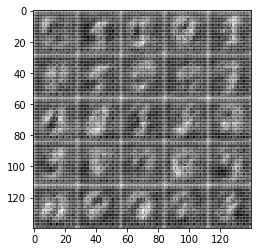

Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 1.2583
Epoch 1/2... Discriminator Loss: 0.4420... Generator Loss: 1.7467
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 4.2990
Epoch 1/2... Discriminator Loss: 0.3821... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.2698... Generator Loss: 2.4804
Epoch 1/2... Discriminator Loss: 0.3394... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.7113
Epoch 1/2... Discriminator Loss: 2.6540... Generator Loss: 0.1183
Epoch 1/2... Discriminator Loss: 0.1975... Generator Loss: 2.5056


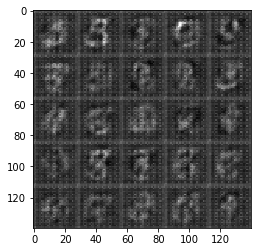

Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.3300
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 1.4431
Epoch 1/2... Discriminator Loss: 0.1277... Generator Loss: 4.2907
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 6.5763
Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 3.8282
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 1.5460
Epoch 1/2... Discriminator Loss: 0.2167... Generator Loss: 3.0412


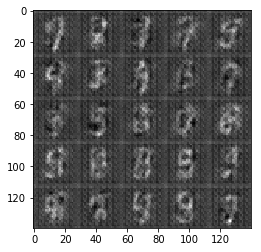

Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 5.2747
Epoch 1/2... Discriminator Loss: 0.0894... Generator Loss: 4.9597
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 5.8992
Epoch 1/2... Discriminator Loss: 0.0890... Generator Loss: 4.1015
Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 5.0764
Epoch 1/2... Discriminator Loss: 0.0970... Generator Loss: 4.5169
Epoch 1/2... Discriminator Loss: 0.1245... Generator Loss: 3.8559
Epoch 1/2... Discriminator Loss: 2.2286... Generator Loss: 0.1899
Epoch 1/2... Discriminator Loss: 0.2271... Generator Loss: 2.4137


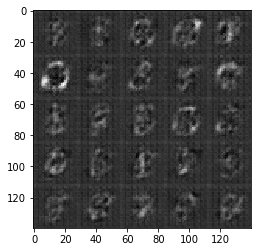

Epoch 1/2... Discriminator Loss: 0.1536... Generator Loss: 2.8688
Epoch 1/2... Discriminator Loss: 0.1066... Generator Loss: 3.7186
Epoch 1/2... Discriminator Loss: 0.1007... Generator Loss: 4.5943
Epoch 1/2... Discriminator Loss: 0.2028... Generator Loss: 2.2396
Epoch 1/2... Discriminator Loss: 0.0873... Generator Loss: 5.5368
Epoch 1/2... Discriminator Loss: 0.1021... Generator Loss: 3.9611
Epoch 1/2... Discriminator Loss: 0.0812... Generator Loss: 5.4513
Epoch 1/2... Discriminator Loss: 0.0837... Generator Loss: 4.5165
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 6.0450
Epoch 1/2... Discriminator Loss: 0.0935... Generator Loss: 4.5325


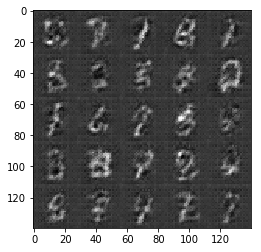

Epoch 1/2... Discriminator Loss: 0.0770... Generator Loss: 4.7242
Epoch 1/2... Discriminator Loss: 0.0953... Generator Loss: 5.3707
Epoch 1/2... Discriminator Loss: 0.0715... Generator Loss: 5.0110
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 1.3155
Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 1.7863
Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.6559
Epoch 1/2... Discriminator Loss: 0.3122... Generator Loss: 2.3433
Epoch 1/2... Discriminator Loss: 0.3377... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 0.3253... Generator Loss: 1.7461


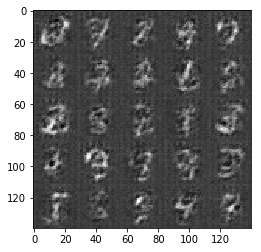

Epoch 1/2... Discriminator Loss: 0.3062... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 0.2635... Generator Loss: 2.0624
Epoch 1/2... Discriminator Loss: 0.2953... Generator Loss: 1.9421
Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.6181
Epoch 1/2... Discriminator Loss: 0.2257... Generator Loss: 2.2994
Epoch 1/2... Discriminator Loss: 0.1965... Generator Loss: 2.4109
Epoch 1/2... Discriminator Loss: 0.2218... Generator Loss: 2.2479
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 0.1724... Generator Loss: 2.6447
Epoch 1/2... Discriminator Loss: 0.1545... Generator Loss: 2.8647


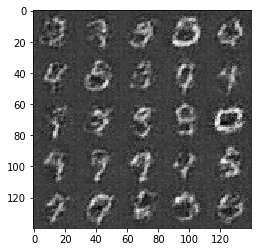

Epoch 1/2... Discriminator Loss: 0.1827... Generator Loss: 2.7938
Epoch 1/2... Discriminator Loss: 0.1900... Generator Loss: 2.5379
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 2.8634
Epoch 1/2... Discriminator Loss: 0.1107... Generator Loss: 3.5950
Epoch 1/2... Discriminator Loss: 0.1535... Generator Loss: 2.7120
Epoch 1/2... Discriminator Loss: 0.1392... Generator Loss: 3.0791
Epoch 1/2... Discriminator Loss: 0.4469... Generator Loss: 1.3679
Epoch 1/2... Discriminator Loss: 0.1847... Generator Loss: 2.5097
Epoch 1/2... Discriminator Loss: 0.1133... Generator Loss: 3.4362
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.1458


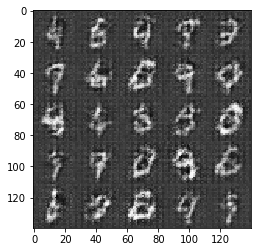

Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 2.0703
Epoch 1/2... Discriminator Loss: 0.2740... Generator Loss: 2.4756
Epoch 1/2... Discriminator Loss: 0.1963... Generator Loss: 2.8092
Epoch 1/2... Discriminator Loss: 0.1620... Generator Loss: 2.8286
Epoch 1/2... Discriminator Loss: 0.1776... Generator Loss: 3.1661
Epoch 1/2... Discriminator Loss: 1.8214... Generator Loss: 0.3273
Epoch 1/2... Discriminator Loss: 0.3111... Generator Loss: 1.7428
Epoch 1/2... Discriminator Loss: 0.2932... Generator Loss: 1.8722
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.4947
Epoch 1/2... Discriminator Loss: 0.2055... Generator Loss: 2.3481


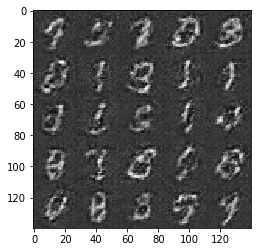

Epoch 1/2... Discriminator Loss: 0.2389... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 0.1737... Generator Loss: 2.5430
Epoch 1/2... Discriminator Loss: 0.3046... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 0.1356... Generator Loss: 2.9485
Epoch 2/2... Discriminator Loss: 0.1827... Generator Loss: 2.6294
Epoch 2/2... Discriminator Loss: 0.0874... Generator Loss: 4.0532
Epoch 2/2... Discriminator Loss: 0.1053... Generator Loss: 3.6000
Epoch 2/2... Discriminator Loss: 0.1719... Generator Loss: 2.6312
Epoch 2/2... Discriminator Loss: 0.3530... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.1610... Generator Loss: 2.7130


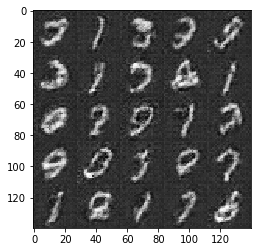

Epoch 2/2... Discriminator Loss: 0.1609... Generator Loss: 2.6182
Epoch 2/2... Discriminator Loss: 0.0931... Generator Loss: 3.9376
Epoch 2/2... Discriminator Loss: 0.0958... Generator Loss: 3.8422
Epoch 2/2... Discriminator Loss: 0.1666... Generator Loss: 2.6722
Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 2.9611
Epoch 2/2... Discriminator Loss: 0.1279... Generator Loss: 3.0281
Epoch 2/2... Discriminator Loss: 0.1788... Generator Loss: 2.5712
Epoch 2/2... Discriminator Loss: 0.0801... Generator Loss: 4.4183
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 4.0572
Epoch 2/2... Discriminator Loss: 0.0910... Generator Loss: 3.9841


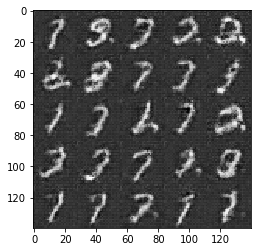

Epoch 2/2... Discriminator Loss: 0.0686... Generator Loss: 5.4634
Epoch 2/2... Discriminator Loss: 0.0983... Generator Loss: 3.6748
Epoch 2/2... Discriminator Loss: 0.0828... Generator Loss: 4.0823
Epoch 2/2... Discriminator Loss: 0.0862... Generator Loss: 3.9757
Epoch 2/2... Discriminator Loss: 0.0914... Generator Loss: 3.8825
Epoch 2/2... Discriminator Loss: 0.0774... Generator Loss: 4.7271
Epoch 2/2... Discriminator Loss: 0.0779... Generator Loss: 4.7186
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.5461
Epoch 2/2... Discriminator Loss: 0.1043... Generator Loss: 3.7212
Epoch 2/2... Discriminator Loss: 0.0871... Generator Loss: 4.0510


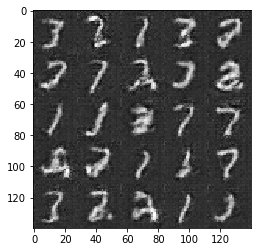

Epoch 2/2... Discriminator Loss: 0.0722... Generator Loss: 5.0215
Epoch 2/2... Discriminator Loss: 0.0685... Generator Loss: 5.6497
Epoch 2/2... Discriminator Loss: 0.0892... Generator Loss: 4.5188
Epoch 2/2... Discriminator Loss: 0.0829... Generator Loss: 4.3818
Epoch 2/2... Discriminator Loss: 0.0871... Generator Loss: 3.9814
Epoch 2/2... Discriminator Loss: 0.1035... Generator Loss: 3.4698
Epoch 2/2... Discriminator Loss: 0.0837... Generator Loss: 4.4481
Epoch 2/2... Discriminator Loss: 0.1549... Generator Loss: 2.8498
Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 6.3964
Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 7.4942


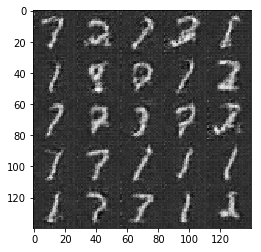

KeyboardInterrupt: 

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    print(mnist_dataset.shape, mnist_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 14.4508
Epoch 1/1... Discriminator Loss: 1.9502... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 0.2149... Generator Loss: 4.4578
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 3.7689
Epoch 1/1... Discriminator Loss: 7.9908... Generator Loss: 22.6331
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 9.4678
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 2.4867
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 4.3052
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 8.1713
Epoch 1/1... Discriminator Loss: 0.1103... Generator Loss: 3.8130


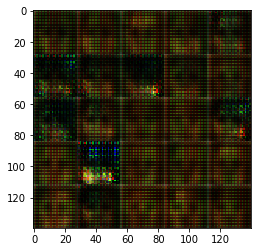

Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 5.3281
Epoch 1/1... Discriminator Loss: 0.1511... Generator Loss: 3.2226
Epoch 1/1... Discriminator Loss: 0.1063... Generator Loss: 3.4492
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 4.0422
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 4.9284
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 2.8979
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 1.4259


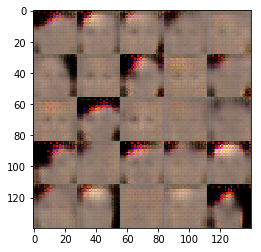

Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 2.8903
Epoch 1/1... Discriminator Loss: 3.3391... Generator Loss: 11.6662
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 3.7415
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.9960


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    print(celeba_dataset.shape, celeba_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.